In [23]:
import numpy as np 
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
from math import sqrt, ceil
from timeit import default_timer as timer

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler


In [24]:
import os
for dirname, _, filenames in os.walk('/home/surya/Documents/final_year_project/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print(os.listdir('/home/surya/Documents/final_year_project/input/'))

/home/surya/Documents/final_year_project/input/data0.pickle
['data0.pickle']


In [25]:
with open('/home/surya/Documents/final_year_project/input/data0.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type

# Preparing y_train and y_validation for using in Keras
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

# Making channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)


x_test: (12630, 32, 32, 3)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
labels: 43
x_train: (86989, 32, 32, 3)
y_test: (12630,)
y_train: (86989, 43)


(81, 32, 32, 3)


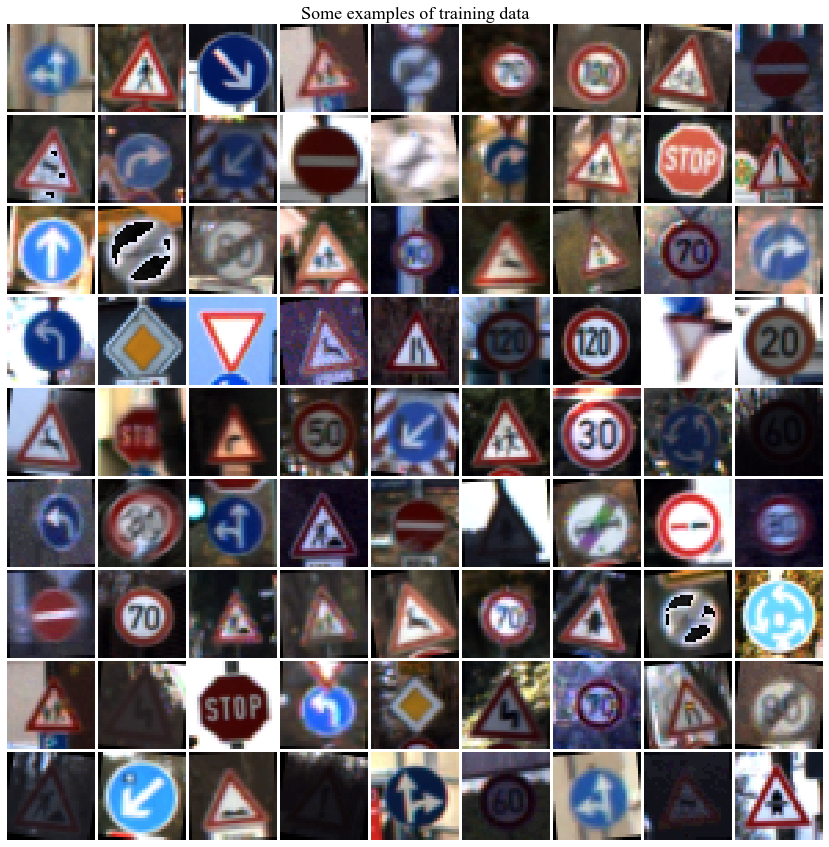

In [26]:
%matplotlib inline

# Preparing function for ploting set of examples
# As input it will take 4D tensor and convert it to the grid
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing some examples of training data
examples = data['x_train'][:81, :, :, :]
print(examples.shape)  # (81, 32, 32, 3)

# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()


In [27]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 15

h = model.fit(data['x_train'][:10], data['y_train'][:10],
              batch_size=5, epochs = epochs,
              validation_data = (data['x_validation'], data['y_validation']),
              callbacks=[annealer], verbose=1)

Epoch 1/15
2/2 [==============================] - 3s 1s/step - loss: 115.3225 - accuracy: 0.0000e+00 - val_loss: 307.3561 - val_accuracy: 0.0138
Epoch 2/15
2/2 [==============================] - 2s 1s/step - loss: 60.2778 - accuracy: 0.3000 - val_loss: 205.9673 - val_accuracy: 0.0546
Epoch 3/15
2/2 [==============================] - 3s 1s/step - loss: 43.5023 - accuracy: 0.2000 - val_loss: 221.0913 - val_accuracy: 0.0268
Epoch 4/15
2/2 [==============================] - 2s 1s/step - loss: 27.8847 - accuracy: 0.6000 - val_loss: 200.3492 - val_accuracy: 0.0168
Epoch 5/15
2/2 [==============================] - 2s 1s/step - loss: 16.8995 - accuracy: 0.5000 - val_loss: 181.2571 - val_accuracy: 0.0512
Epoch 6/15
2/2 [==============================] - 2s 1s/step - loss: 4.5465 - accuracy: 0.9000 - val_loss: 189.9642 - val_accuracy: 0.0535
Epoch 7/15
2/2 [==============================] - 2s 1s/step - loss: 2.5261 - accuracy: 0.8000 - val_loss: 194.6851 - val_accuracy: 0.0544
Epoch 8/15
2/2 [=

In [29]:
print('Epochs={0:d}, training accuracy={1:.5f}, validation accuracy={2:.5f}'.\
      format(epochs, max(h.history['accuracy']), max(h.history['val_accuracy'])))


Epochs=15, training accuracy=1.00000, validation accuracy=0.06621


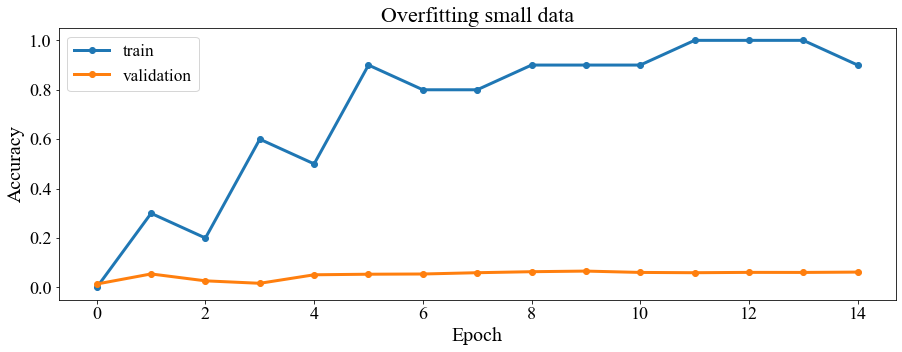

In [30]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['font.family'] = 'Times New Roman'

fig = plt.figure()
plt.plot(h.history['accuracy'], '-o', linewidth=3.0)
plt.plot(h.history['val_accuracy'], '-o', linewidth=3.0)
plt.title('Overfitting small data', fontsize=22)
plt.legend(['train', 'validation'], loc='upper left', fontsize='xx-large')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.tick_params(labelsize=18)

# Showing the plot
plt.show()


In [42]:
start = timer()
temp = model.predict(data['x_test'][:1, :, :, :])
end = timer()

In [44]:
%matplotlib inline

# Preparing image for predicting from test dataset
x_input = data['x_test'][100:101]
print(x_input.shape)
y_input = data['y_test'][100:101]
print(y_input)

(1, 32, 32, 3)
[3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


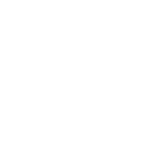

In [47]:
plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
plt.imshow(x_input[0, :, :, :])
plt.axis('off')
plt.show()

In [48]:
scores = model.predict(x_input)
print(scores)


[[0.0000000e+00 0.0000000e+00 2.9765468e-36 0.0000000e+00 3.7157625e-30
  0.0000000e+00 0.0000000e+00 2.2482226e-20 0.0000000e+00 0.0000000e+00
  1.4410682e-27 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.0745816e-37
  0.0000000e+00 0.0000000e+00 2.6605128e-31 0.0000000e+00 6.6799424e-14
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 2.3272786e-38]]


In [49]:
prediction = np.argmax(scores)
print('ClassId:', prediction)

ClassId: 17
